<a href="https://colab.research.google.com/github/zkysfls/CSCI-6170/blob/main/CSCI6170_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyTDC

  Using cached pytdc-1.1.15.tar.gz (154 kB)
  Preparing metadata (setup.py) ... done
  Using cached accelerate-0.33.0-py3-none-any.whl.metadata (18 kB)
  Using cached dataclasses-0.6-py3-none-any.whl.metadata (3.0 kB)
  Using cached datasets-2.19.2-py3-none-any.whl.metadata (19 kB)
  Using cached evaluate-0.4.2-py3-none-any.whl.metadata (9.3 kB)
  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata (4.9 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached transformers-4.50.3-py3-none-any.whl.metadata (39 kB)
INFO: pip is looking at multiple versions of pytdc to determine which version is compatible with other requirements. This could take a while.
  Using cached pytdc-1.1.14.tar.gz (151 kB)
  Preparing metadata (setup.py) ... done
  Using cached scikit-learn-1.2.2.tar.gz (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... 

In [1]:


from tdc.single_pred import ADME
from tdc.chem_utils import MolConvert
import numpy as np
data = ADME(name = 'HIA_Hou')
split = data.get_split(method = 'scaffold')
train_drug = split['train']['Drug'].to_list()
train_Y = np.array(split['train']['Y'].to_list())
valid_drug = split['valid']['Drug'].to_list()
valid_Y = split['valid']['Y'].to_list()
test_drug = split['test']['Drug'].to_list()
test_Y = np.array(split['test']['Y'].to_list())


converter = MolConvert(src = 'SMILES', dst = 'MACCS')
train_X = converter(train_drug)
valid_X = converter(valid_drug)
test_X = converter(test_drug)
print(train_X.shape, valid_X.shape, test_X.shape)



Downloading...
100%|██████████| 40.1k/40.1k [00:00<00:00, 1.09MiB/s]
Loading...
Done!
100%|██████████| 578/578 [00:00<00:00, 638.13it/s]


(404, 167) (57, 167) (117, 167)


In [2]:


import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# 1. prepare data
feature_names = [f'MACCS_{i}' for i in range(167)]
df = pd.DataFrame(np.vstack([train_X, valid_X, test_X]), columns=feature_names)
print(f"Original Shape: {df.shape}")

# 2. Drop Constant and Duplicate Columns
# Drop constant columns (variance = 0)
const_cols = [col for col in df.columns if df[col].nunique() <= 1]
df_clean = df.drop(columns=const_cols)
print(f"Dropped {len(const_cols)} constant columns.")
# Drop duplicate columns
df_clean = df_clean.T.drop_duplicates().T
print(f"Shape after cleaning constants/duplicates: {df_clean.shape}")

# 3. VIF Calculation Function
def calculate_vif(data):
    # Add intercept for VIF calculation
    X_const = add_constant(data.astype(float))
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    # Compute VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1)
                       for i in range(data.shape[1])]
    return vif_data

# 4. Iterative Removal of High VIF Features
def remove_high_vif(data, threshold=5.0):
    data_new = data.copy()
    dropped = []

    print(f"\nStarting iterative VIF removal (Threshold={threshold})...")
    while True:
        # Calculate VIF
        vif_df = calculate_vif(data_new)
        max_vif = vif_df['VIF'].max()

        # Check if max VIF exceeds threshold
        if max_vif > threshold:
            feature_to_drop = vif_df.sort_values('VIF', ascending=False).iloc[0]['Feature']
            print(f"Dropping {feature_to_drop} (VIF={max_vif:.2f})")
            data_new = data_new.drop(columns=[feature_to_drop])
            dropped.append(feature_to_drop)
        else:
            print("All features are within VIF threshold.")
            break

    return data_new, vif_df


df_final, final_vif = remove_high_vif(df_clean, threshold=10.0)

print("\nFinal Selected Features:")
print(final_vif.head())



Original Shape: (578, 167)
Dropped 17 constant columns.
Shape after cleaning constants/duplicates: (578, 147)

Starting iterative VIF removal (Threshold=10.0)...
Dropping MACCS_32 (VIF=inf)
Dropping MACCS_118 (VIF=197.91)
Dropping MACCS_55 (VIF=171.87)
Dropping MACCS_60 (VIF=121.29)
Dropping MACCS_134 (VIF=56.56)
Dropping MACCS_94 (VIF=54.70)
Dropping MACCS_67 (VIF=47.50)
Dropping MACCS_102 (VIF=36.92)
Dropping MACCS_63 (VIF=34.56)
Dropping MACCS_110 (VIF=29.31)
Dropping MACCS_73 (VIF=27.55)
Dropping MACCS_58 (VIF=24.31)
Dropping MACCS_107 (VIF=23.03)
Dropping MACCS_81 (VIF=21.46)
Dropping MACCS_122 (VIF=20.86)
Dropping MACCS_105 (VIF=18.03)
Dropping MACCS_24 (VIF=17.05)
Dropping MACCS_119 (VIF=16.90)
Dropping MACCS_76 (VIF=15.50)
Dropping MACCS_83 (VIF=15.13)
Dropping MACCS_121 (VIF=13.57)
Dropping MACCS_49 (VIF=13.39)
Dropping MACCS_124 (VIF=12.53)
Dropping MACCS_8 (VIF=11.94)
Dropping MACCS_117 (VIF=11.74)
Dropping MACCS_48 (VIF=10.19)
All features are within VIF threshold.

Final S

In [3]:
df_viz = df_final.copy()
df_viz['Target'] = np.concatenate([train_Y, valid_Y, test_Y])
print(df_viz.shape)

(578, 122)


In [4]:
df_viz

,MACCS_11,MACCS_13,MACCS_14,MACCS_15,MACCS_16,MACCS_17,MACCS_19,MACCS_21,MACCS_22,MACCS_23,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,Target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1
574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


**Task 1**

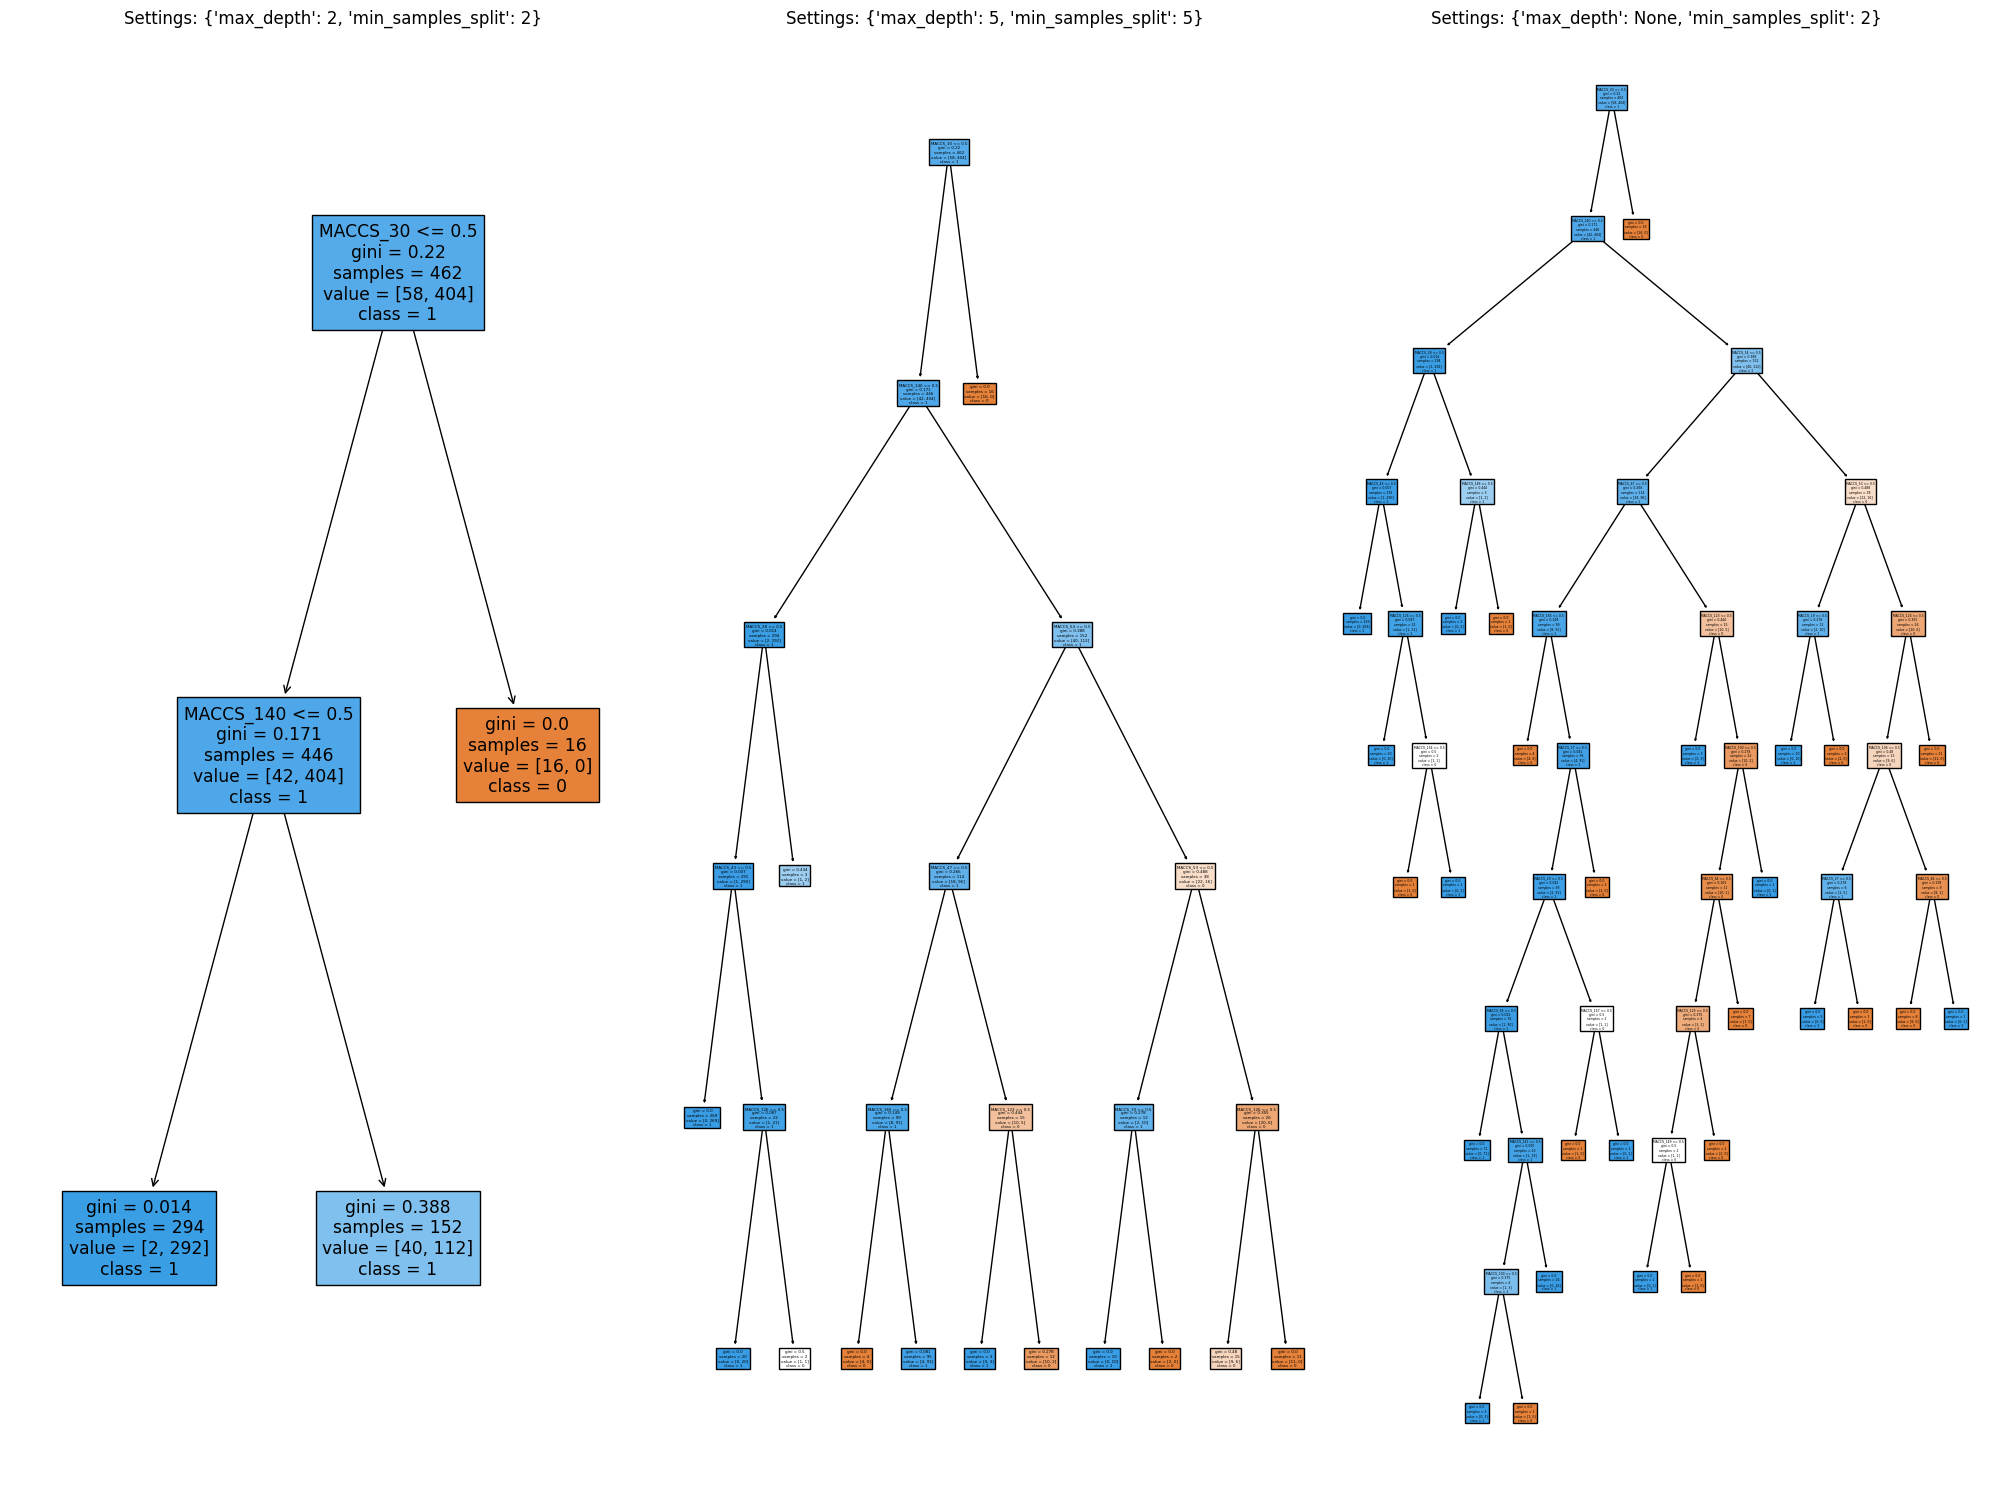

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df_viz.drop('Target', axis=1)
y = df_viz['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = [
    {'max_depth': 2, 'min_samples_split': 2},
    {'max_depth': 5, 'min_samples_split': 5},
    {'max_depth': None, 'min_samples_split': 2}
]

plt.figure(figsize=(20, 15))
for i, p in enumerate(params):
    clf = DecisionTreeClassifier(**p, random_state=42)
    clf.fit(X_train, y_train)

    plt.subplot(1, 3, i+1)
    plot_tree(clf, filled=True, feature_names=X.columns, class_names=['0', '1'])
    plt.title(f"Settings: {p}")

plt.tight_layout()
plt.show()

We choose three sets of parameters: {'max_depth': 2, 'min_samples_split': 2}, {'max_depth': 5, 'min_samples_split': 5},
{'max_depth': None, 'min_samples_split': 2}. And we plot them above.

The left tree is the {'max_depth': 2, 'min_samples_split': 2}. This is a very shallow tree. It only performs a maximum of two splits. And it only uses two features (MACCS_30 and MACCS_140) to make every prediction. This tree has high bias but low variance. While it is easy to understand, it likely underfits the data. The leaf nodes still have relatively high Gini impurity scores, meaning the groups are not yet pure.

The middle tree is the {'max_depth': 5, 'min_samples_split': 5}. This tree has grown significantly larger than the left one, captures more granular patterns. It identifies complex combinations of features that lead to specific outcomes. Many leaf nodes now show much lower Gini scores or reach 0.0 for small clusters.

The right tree is the {'max_depth': None, 'min_samples_split': 2}. The tree is fully grown. Without a depth limit, it continues splitting until every leaf is either perfectly pure or contains only a single sample. The structure is extremely dense. This model has low bias but very high variance. It has likely overfitted the training data.

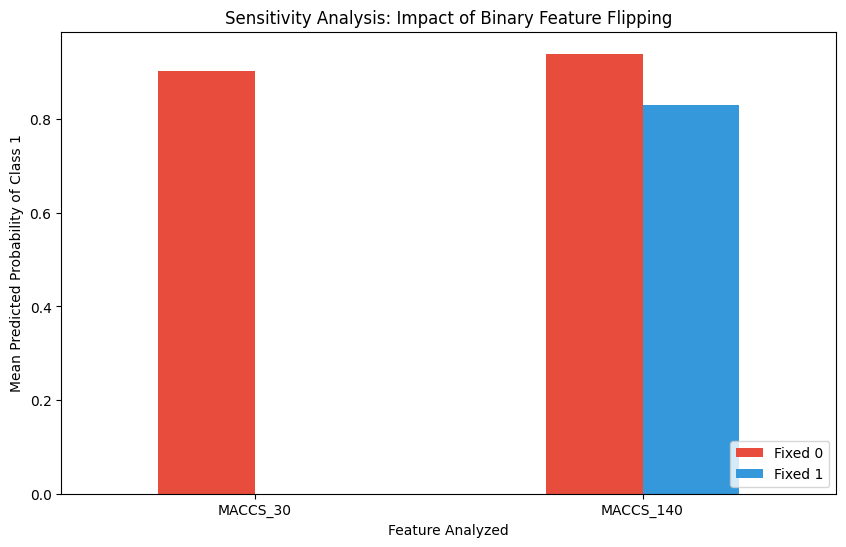

Sensitivity Scores (Higher = More Impactful):
MACCS_30     0.903796
MACCS_140    0.109498
Name: Sensitivity, dtype: float64


In [10]:

def calculate_binary_sensitivity(model, X_data, feature_name):

    X_zero = X_data.copy()
    X_one = X_data.copy()


    X_zero[feature_name] = 0
    X_one[feature_name] = 1


    prob_zero = model.predict_proba(X_zero)[:, 1].mean()
    prob_one = model.predict_proba(X_one)[:, 1].mean()


    sensitivity_index = abs(prob_one - prob_zero)

    return prob_zero, prob_one, sensitivity_index


feature_1 = 'MACCS_30'
feature_2 = 'MACCS_140'


results = {}
for feat in [feature_1, feature_2]:
    p0, p1, sens = calculate_binary_sensitivity(clf, X_test, feat)
    results[feat] = {'Fixed 0': p0, 'Fixed 1': p1, 'Sensitivity': sens}


res_df = pd.DataFrame(results).T
res_df[['Fixed 0', 'Fixed 1']].plot(kind='bar', figsize=(10, 6), color=['#e74c3c', '#3498db'])
plt.title("Sensitivity Analysis: Impact of Binary Feature Flipping")
plt.ylabel("Mean Predicted Probability of Class 1")
plt.xlabel("Feature Analyzed")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

print("Sensitivity Scores (Higher = More Impactful):")
print(res_df['Sensitivity'])

In machine learning, Sensitivity Analysis identifies which features have the most significant impact on a model's predictions and how changes in those features alter the decision boundary. In our model, since the data's feature is also binary, we choose two features and set them to be all 0 or all 1 across all dataset to see how prediction is changed.

Firstly for feature MACCS_30. When MACCS_30 is fixed to 0 (red bar), the average probability of the model predicting Class 1 is very high (~0.9). However, when it is fixed to 1 (blue bar), the probability drops to effectively zero. This indicate that this feature has very high sensitivity. Also it match our observation in decision tree where MACCS_30 is the root node. Flipping this single bit from 0 to 1 completely changes the model's outcome for nearly the entire dataset.

Second for feature MACCS_140. When MACCS_140 is fixed to 0, the mean probability is ~0.93. When it is flipped to 1, the probability drops slightly to ~0.83. This means it has low sensitivity. While the model does use MACCS_140 for decision-making, the overall impact on the final prediction is much smaller compared to MACCS_30.

**Task 2**

In [11]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score

In [12]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)


metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1_score': 'f1'
}

folds_to_test = [5, 10, 15]
results = []

for k in folds_to_test:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for name, model in [("Random Forest", rf_model), ("XGBoost", xgb_model)]:
        cv_results = cross_validate(model, X, y, cv=skf, scoring=metrics)

        results.append({
            "Model": name,
            "Folds": k,
            "Accuracy": np.mean(cv_results['test_accuracy']),
            "Precision": np.mean(cv_results['test_precision']),
            "F1-Score": np.mean(cv_results['test_f1_score'])
        })


results_df = pd.DataFrame(results)
print(results_df)

           Model  Folds  Accuracy  Precision  F1-Score
0  Random Forest      5  0.942954   0.950332  0.967655
1        XGBoost      5  0.946402   0.963279  0.969128
2  Random Forest     10  0.941168   0.948699  0.966750
3        XGBoost     10  0.951603   0.965511  0.972223
4  Random Forest     15  0.941296   0.950907  0.966697
5        XGBoost     15  0.956815   0.969593  0.975254


We choose random forest (Bagging) and XGBoost (Boosting).

XGBoost shows a clear upward trend across all metrics as the number of folds increases. As k goes from 5 to 15, Accuracy moves from 0.946 to 0.956, and F1-Score moves from 0.969 to 0.975. Higher k means model train on a larger percentage of the data in each iteration. Since XGBoost is a boosting algorithm that builds trees sequentially to correct previous errors, it thrives on this additional data to fine-tune its gradient descent.

Random forest perform remarkably consistent regardless of the number of folds, as its accuracy stays almost identical. Random Forest relies on bagging. Once it has captured the primary statistical variance, adding a few more training rows (by increasing folds) doesn't significantly change the average vote of the forest.

**Task 3**


--- Statistical Significance (Paired t-test) ---
XGBoost vs Random Forest: p-value = 0.0806 (Not Significant)
XGBoost vs Decision Tree: p-value = 0.0495 (Significant)


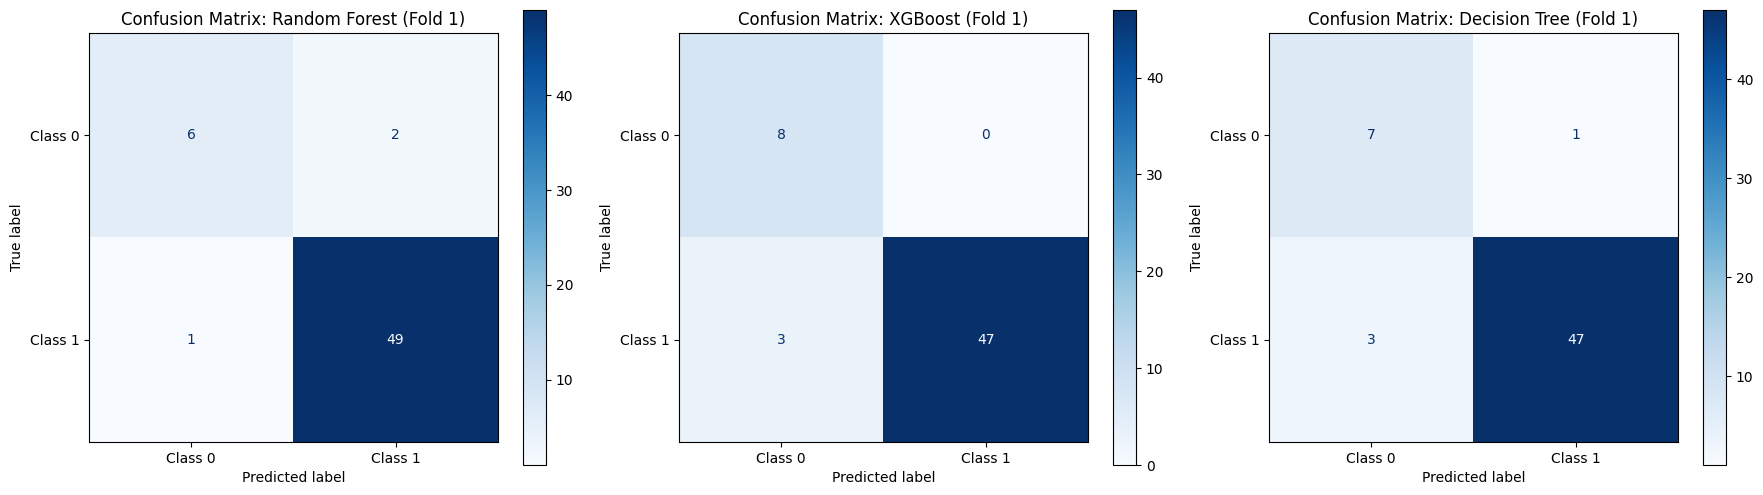


--- Model Performance Summary ---
           Model  Accuracy  Precision  F1-Score
0  Random Forest  0.941168   0.948699  0.966750
1        XGBoost  0.951603   0.965511  0.972223
2  Decision Tree  0.927435   0.964335  0.957740


In [13]:
from scipy.stats import ttest_rel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X = df_viz.drop('Target', axis=1)
y = df_viz['Target']
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

dtc_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1_score': 'f1'
}

results = []
raw_accuracies = {}
for name, model in [("Random Forest", rf_model), ("XGBoost", xgb_model), ("Decision Tree", dtc_model)]:
    cv_results = cross_validate(model, X, y, cv=skf, scoring=metrics)
    raw_accuracies[name] = cv_results['test_accuracy']
    results.append({
            "Model": name,
            "Accuracy": np.mean(cv_results['test_accuracy']),
            "Precision": np.mean(cv_results['test_precision']),
            "F1-Score": np.mean(cv_results['test_f1_score'])
        })

print("\n--- Statistical Significance (Paired t-test) ---")
for comparison_model in ["Random Forest", "Decision Tree"]:
    t_stat, p_val = ttest_rel(raw_accuracies["XGBoost"], raw_accuracies[comparison_model])
    status = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"XGBoost vs {comparison_model}: p-value = {p_val:.4f} ({status})")



train_idx, test_idx = next(skf.split(X, y))
X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]


models_to_plot = [("Random Forest", rf_model), ("XGBoost", xgb_model), ("Decision Tree", dtc_model)]

plt.figure(figsize=(18, 5))

for i, (name, model) in enumerate(models_to_plot):
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    plt.subplot(1, 3, i + 1)
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix: {name} (Fold 1)")

plt.tight_layout()
plt.show()

# Display results table
import pandas as pd
print("\n--- Model Performance Summary ---")
print(pd.DataFrame(results))

The Decision Tree achieved the lowest Accuracy (0.927) and F1-Score (0.957). The statistical test confirms it is significantly worse than XGBoost. Because Decision Tree is a greedy algorithm that attempts to create a perfect fit for the training data. This often results in high variance. Its high variance prevents it from generalizing well to the unseen test folds. It is the least robust of the three models.

Random Forest reached a solid Accuracy of 0.941. Notably, the paired t-test showed no significant difference between Random Forest and XGBoost. The bagging strategic effectively cancels out the individual variance of each tree.  While this might slightly increase bias, the massive reduction in variance leads to a much more stable and accurate model than a single tree.

XGBoost produced the highest scores across all metrics (Accuracy: 0.951, F1-Score: 0.972). It was the only model to achieve 0 False Positives. XGBoost uses Boosting. This allows it to reach an extremely low bias state. Also it use regularization to avoid massive spike in variance. The results show that XGBoost successfully found the sweet spot: it has lower bias than Random Forest but manages its variance well enough to outperform the other models consistently.

**Task 4**

In [14]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0]
}


xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring=['accuracy', 'f1'], refit='f1',
                           cv=5, verbose=1)

grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.6}


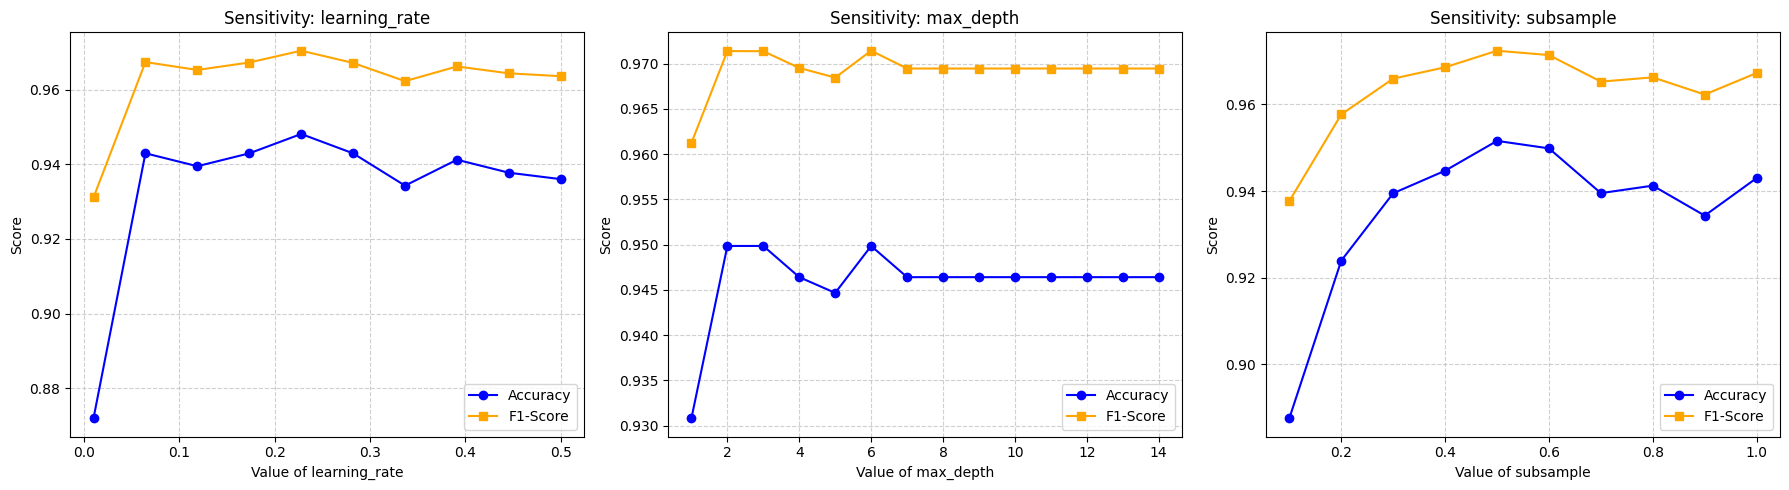

In [16]:
def perform_sensitivity(param_name, values, fixed_params):
    acc_scores = []
    f1_scores = []

    for val in values:

        current_params = fixed_params.copy()
        current_params[param_name] = val


        model = XGBClassifier(**current_params, n_estimators=100, random_state=42)
        cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'f1'])

        acc_scores.append(np.mean(cv_results['test_accuracy']))
        f1_scores.append(np.mean(cv_results['test_f1']))

    return acc_scores, f1_scores


sens_ranges = {
    'learning_rate': np.linspace(0.01, 0.5, 10),
    'max_depth': range(1, 15),
    'subsample': np.linspace(0.1, 1.0, 10)
}


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (param, values) in enumerate(sens_ranges.items()):
    accs, f1s = perform_sensitivity(param, values, best_params)

    axes[i].plot(values, accs, label='Accuracy', marker='o', color='blue')
    axes[i].plot(values, f1s, label='F1-Score', marker='s', color='orange')
    axes[i].set_title(f'Sensitivity: {param}')
    axes[i].set_xlabel(f'Value of {param}')
    axes[i].set_ylabel('Score')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

We perform grid search on learning rate, max depth and subsample. And analyse their sensitivity.

Firstly for learning rate. There is a massive performance jump between a learning rate of 0.01 and 0.1. The model reaches its peak performance around 0.22, after which accuracy and F1-score begin decline. The model is highly sensitive at very low values. At 0.01, the model is underfitting because the steps taken toward the optimum are too small for the 100 iterations.

Second for max depth. Performance is at its lowest at depth 1. There is a sharp increase at depth 2, and then the model remains extremely stable from depth 3 all the way to 14. This parameter shows low sensitivity once it passes a threshold of 3. Because the dataset does not have much data, increasing the complexity of the trees beyond depth 3 does not provide any marginal gain in accuracy.

Finally for subsample. Performance is poor at 0.1, rises steadily to a peak at 0.5 - 0.6, and then fluctuates as it approaches 1.0. The model is moderately sensitive to subsampling. If the subsample is too low (e.g., 0.1), each tree only sees 10% of the data, which is insufficient to learn the underlying signal.